In [1]:
import sys
from utils import data_utils
import helper
import matplotlib.pyplot as plt
from utils import training_utils
from utils import data_utils
import torch
from model import models
import json
import os
from model import lightning_models
import math
import pytorch_lightning as pl

In [2]:
config = helper.Config("./simulations",default_config_file="./default_configs/default_config_cifar10.ini")
if config.INFO["fix_random_seed"]:
    pl.seed_everything(137) # To be reproducable

Seed set to 137


Loading default settings...
[FT]does not exist in the config file
[TL]does not exist in the config file
[FT]does not exist in the config file
[TL]does not exist in the config file
[INFO]
num_nodes = 1
gpus_per_node = 1
cpus_per_gpu = 2
precision = 16-mixed
fix_random_seed = True
strategy = auto

[DATA]
dataset = CIFAR10
n_views = 8
augmentations = ['RandomResizeCrop', 'GaussianBlur', 'RandomGrayscale', 'ColorJitter', 'RandomHorizontalFlip']
crop_size = 32
crop_min_scale = 0.08
crop_max_scale = 1.0
hflip_prob = 0.5
blur_kernel_size = 1
blur_prob = 0.5
grayscale_prob = 0.2
jitter_brightness = 0.8
jitter_contrast = 0.8
jitter_saturation = 0.8
jitter_hue = 0.2
jitter_prob = 0.8

[SSL]
backbone = resnet18
backbone_out_dim = 2048
use_projection_header = True
proj_out_dim = 256
optimizer = LARS
lr = 0.1
lr_scale = linear
momentum = 0.99
weight_decay = 0.1
lars_eta = 0.1
loss_function = EllipsoidPackingLoss
lw0 = 1.0
lw1 = 1.0
lw2 = 1.0
rs = 3.0
warmup_epochs = 1
n_epochs = 2
batch_size = 64
s

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


781


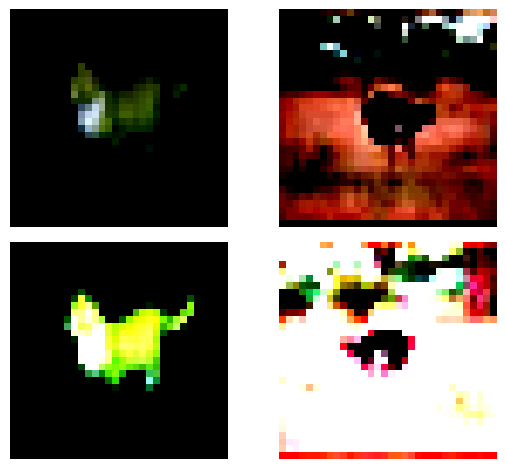

In [3]:
# for multi-gpu trainning, effective batch size = batch_size*num_gpus
ssl_batch_size = config.SSL["batch_size"] // (config.INFO["num_nodes"]*config.INFO["gpus_per_node"])
ssl_train_loader,ssl_test_loader,ssl_val_loader = data_utils.get_dataloader(config.DATA,ssl_batch_size,num_workers=config.INFO["cpus_per_gpu"],validation=False)
# test_loader and val_loader are not necessary
del ssl_test_loader
del ssl_val_loader
imgs,labels = next(iter(ssl_train_loader))
img_list, label_list = [],[]
for i_view in range(2):
    for j_img in range(2):
        img_list.append(imgs[i_view][j_img])
        #label_list.append(classes[labels[i_view][j_img]])
data_utils.show_images(img_list,2,2,label_list)
print(len(ssl_train_loader))

In [4]:
if config.SSL["lr_scale"] == "linear":
    ssl_lr = config.SSL["lr"]*config.SSL["batch_size"]/256.0 # lr ~ 0.1
elif config.SSL["lr_scale"] == "sqrt":
    ssl_lr = config.SSL["lr"]*math.sqrt(config.SSL["batch_size"]) # lr ~ 0.05
if "CIFAR" in config.DATA["dataset"] or "MNIST" in config.DATA["dataset"]:
    prune_backbone = True
else:
    prune_backbone = False
ssl_model = lightning_models.CLAP(backbone_name = config.SSL["backbone"],
                                  backbone_out_dim = config.SSL["backbone_out_dim"],
                                  prune = prune_backbone,
                                  use_projection_header=config.SSL["use_projection_header"],
                                  proj_out_dim = config.SSL["proj_out_dim"],
                                  optim_name = config.SSL["optimizer"],
                                  lr = ssl_lr,
                                  momentum = config.SSL["momentum"],
                                  weight_decay = config.SSL["weight_decay"],
                                  eta = config.SSL["lars_eta"],
                                  warmup_epochs = config.SSL["warmup_epochs"],
                                  n_epochs = config.SSL["n_epochs"],
                                  n_views = config.DATA["n_views"],
                                  batch_size = config.SSL["batch_size"],
                                  lw0 = config.SSL["lw0"],
                                  lw1 = config.SSL["lw1"],
                                  lw2 = config.SSL["lw2"],
                                  rs = config.SSL["rs"])

In [5]:
ssl_dir = os.path.join(config.loc,"ssl")
if not os.path.isdir(ssl_dir):
    os.makedirs(ssl_dir)
ssl_model = lightning_models.train_clap(model=ssl_model, 
                                        train_loader = ssl_train_loader,
                                        max_epochs=config.SSL["n_epochs"],
                                        every_n_epochs = config.SSL["save_every_n_epochs"],
                                        precision = config.INFO["precision"],
                                        checkpoint_path=ssl_dir)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Found pretrained model at ./simulations/ssl/ssl-epoch=1.ckpt, loading...


In [6]:
lc_batch_size = config.LC["batch_size"] // (config.INFO["num_nodes"]*config.INFO["gpus_per_node"])
if config.LC["apply_simple_augmentations"]:
    data_info = {"dataset":config.DATA["dataset"],"batch_size":lc_batch_size,"n_views":2,"augmentations":["RandomResizeCrop","RandomHorizontalFlip"],
                 "crop_size":config.DATA["crop_size"],"crop_min_scale":0.08,"crop_max_scale":1.0,"hflip_prob":0.5}
else:
    data_info = {"dataset":config.DATA["dataset"],"batch_size":lc_batch_size,"n_views":1,"augmentations":[]}
# need to specify the location of the data for imagenet
if "IMAGENET1K" in config.DATA["dataset"]:
    data_info["imagenet_train_dir"] = config.DATA["imagenet_train_dir"]
    data_info["imagenet_val_dir"] = config.DATA["imagenet_val_dir"]

lc_train_loader,lc_test_loader,lc_val_loader = data_utils.get_dataloader(data_info,lc_batch_size,num_workers=config.INFO["cpus_per_gpu"])
lc_dir = os.path.join(config.loc,"lc")
if not os.path.isdir(lc_dir):
    os.makedirs(lc_dir)
if config.LC["lr_scale"] == "linear":
    lc_lr = config.LC["lr"]*config.LC["batch_size"]/256.0 # lr ~ 0.1
elif config.LC["lr_scale"] == "sqrt":
    lc_lr = config.LC["lr"]*math.sqrt(config.LC["batch_size"]) # lr ~ 0.05
# load the backbone from the check point
last_ssl_ckpt = lightning_models.get_top_n_latest_checkpoints(ssl_dir,1)[0]
ssl_model = lightning_models.CLAP.load_from_checkpoint(last_ssl_ckpt)
ssl_model.backbone.remove_projection_header()
lc_model = lightning_models.LinearClassification(
                 backbone= ssl_model.backbone,
                 in_dim = config.SSL["backbone_out_dim"],
                 out_dim = config.LC["output_dim"],
                 use_batch_norm = config.LC["use_batch_norm"],
                 optim_name = config.LC["optimizer"],
                 lr = lc_lr, 
                 momentum = config.LC["momentum"],
                 weight_decay = config.LC["weight_decay"],
                 n_epochs = config.LC["n_epochs"])
lc_model = lightning_models.train_lc(linear_model = lc_model,
            train_loader = lc_train_loader,
            test_loader = lc_test_loader,
            val_loader = lc_val_loader,
            max_epochs = config.LC["n_epochs"],
            every_n_epochs = config.LC["save_every_n_epochs"],
            checkpoint_path = lc_dir,
            precision = config.INFO["precision"],
            restart = config.LC["restart_training"])

Files already downloaded and verified
Files already downloaded and verified


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/richard/miniconda3/envs/dl_env/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/richard/Documents/code/clap/simulations/lc exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type        | Params | Mode 
---------------------------------------------------
0 | backbone   | BackboneNet | 12.2 M | train
1 | linear_net | BnLinearNet | 24.6 K | train
------------------

start fitting


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

fowarding
fowarding


Training: |                                               | 0/? [00:00<?, ?it/s]

fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding


Validation: |                                             | 0/? [00:00<?, ?it/s]

fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding


Validation: |                                             | 0/? [00:00<?, ?it/s]

fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding


Validation: |                                             | 0/? [00:00<?, ?it/s]

fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding


Validation: |                                             | 0/? [00:00<?, ?it/s]

fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding


`Trainer.fit` stopped: `max_epochs=4` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                | 0/? [00:00<?, ?it/s]

fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
fowarding
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
───────────────────────────────────────────────────────

TypeError: LinearClassification.__init__() missing 1 required positional argument: 'backbone'

In [ ]:
# Fine-tune or semi-supervised learning
if len(config.FT) > 0:
    ft_batch_size = config.FT["batch_size"] // (config.INFO["num_nodes"]*config.INFO["gpus_per_node"])
    for dataset in ["IMAGENET1K-1%","IMAGENET1K-10%"]:
        if config.FT["apply_simple_augmentations"]:
            data_info = {"dataset":dataset,"batch_size":lc_batch_size,"n_views":2,"augmentations":["RandomResizeCrop","RandomHorizontalFlip"],
                 "crop_size":config.DATA["crop_size"],"crop_min_scale":0.08,"crop_max_scale":1.0,"hflip_prob":0.5}
        else:
            data_info = {"dataset":dataset,"batch_size":lc_batch_size,"n_views":1,"augmentations":[]}
        # add the location for imagenet dataset
        data_info["imagenet_train_dir"] = config.DATA["imagenet_train_dir"]
        data_info["imagenet_val_dir"] = config.DATA["imagenet_val_dir"]
        ft_train_loader,ft_test_loader,ft_val_loader = data_utils.get_dataloader(data_info,ft_batch_size,num_workers=config.INFO["cpus_per_gpu"])
        ft_dir = os.path.join(config.loc,"ft-"+dataset)
        if not os.path.isdir(ft_dir):
            os.makedirs(ft_dir)
        if config.FT["lr_scale"] == "linear":
            ft_lr = config.FT["lr"]*config.FT["batch_size"]/256.0 # lr ~ 0.1
        elif config.LC["lr_scale"] == "sqrt":
            ft_lr = config.FT["lr"]*math.sqrt(config.FT["batch_size"]) # lr ~ 0.05
        # load the backbone from the checkpoint
        last_ssl_ckpt = lightning_models.get_top_n_latest_checkpoints(ssl_dir,1)[0]
        ssl_model = lightning_models.CLAP.load_from_checkpoint(last_ssl_ckpt)
        ssl_model.backbone.remove_projection_header()
        # load the linear classifier from the checkpoint
        last_lc_ckpt = lightning_models.get_top_n_latest_checkpoints(lc_dir,1)[0]
        lc_model = lightning_models.LinearClassification.load_from_checkpoint(last_lc_ckpt)
        ft_model = lightning_models.FineTune(backbone = ssl_model.backbone,
                    linear_net= lc_model.linear_net,
                    optim_name = config.FT["optimizer"],
                    lr = ft_lr, 
                    momentum = config.FT["momentum"],
                    weight_decay = config.LC["weight_decay"],
                    n_epochs = config.FT["n_epochs"])
        ft_model = lightning_models.train_finetune(
                    finetune_model = ft_model,
                    train_loader = ft_test_loader,
                    test_loader = ft_test_loader,
                    val_loader = ft_val_loader,
                    max_epochs = config.FT["n_epochs"],
                    every_n_epochs = config.FT["save_every_n_epochs"],
                    checkpoint_path = ft_dir,
                    precision= config.INFO["precision"],
                    restart = config.FT["restart_training"])

In [ ]:
# Transfer learning(freeze backbone)
if len(config.TL) > 0:
    tl_output_dim = {"CIFAR100":100,
                    "FOOD101":101,
                    "FLOWERS102":102}
    for dataset in ["CIFAR100","FOOD101","FLOWERS102"]:
        tl_batch_size = config.TL["batch_size"] // (config.INFO["num_nodes"]*config.INFO["gpus_per_node"])
        if config.LC["apply_simple_augmentations"]:
            data_info = {"dataset":dataset,"batch_size":tl_batch_size,"n_views":2,"augmentations":["RandomResizeCrop","RandomHorizontalFlip"],
                 "crop_size":config.DATA["crop_size"],"crop_min_scale":0.08,"crop_max_scale":1.0,"hflip_prob":0.5}
        else:
            data_info = {"dataset":config.INFO["dataset"],"batch_size":tl_batch_size,"n_views":1,"augmentations":[]}
        tl_train_loader,tl_test_loader,tl_val_loader = data_utils.get_dataloader(data_info,lc_batch_size,num_workers=config.INFO["cpus_per_gpu"])
        tl_dir = os.path.join(config.loc,"tl-"+dataset)
        if not os.path.isdir(tl_dir):
            os.makedirs(tl_dir)

        if config.TL["lr_scale"] == "linear":
            tl_lr = config.TL["lr"]*config.TL["batch_size"]/256.0 # lr ~ 0.1
        elif config.TL["lr_scale"] == "sqrt":
            tl_lr = config.TL["lr"]*math.sqrt(config.TL["batch_size"]) # lr ~ 0.05

        # load the backbone from the checkpoint
        last_ssl_ckpt = lightning_models.get_top_n_latest_checkpoints(ssl_dir,1)[0]
        ssl_model = lightning_models.CLAP.load_from_checkpoint(last_ssl_ckpt)
        ssl_model.backbone.remove_projection_header()
        
        tl_model = lightning_models.LinearClassification(
                    backbone = ssl_model.backbone,
                    in_dim = config.SSL["backbone_out_dim"],
                    out_dim = tl_output_dim[dataset],
                    use_batch_norm = config.TL["use_batch_norm"],
                    optim_name = config.TL["optimizer"],
                    lr = tl_lr, 
                    momentum = config.TL["momentum"],
                    weight_decay = config.TL["weight_decay"],
                    n_epochs = config.TL["n_epochs"])

        tl_model = lightning_models.train_lc(
                    linear_model = tl_model,
                    train_loader = tl_train_loader,
                    val_loader = tl_val_loader,
                    test_loader = tl_test_loader,
                    every_n_epochs = config.TL["save_every_n_epochs"],
                    max_epochs = config.TL["n_epochs"],
                    precision = config.INFO["precision"],
                    checkpoint_path = tl_dir,
                    mode = config.TL["training_mode"]) 